In [14]:
# install machine gnostics
# recommended to run in a new virtual environment

# !pip install machinegnostics #<-- Uncomment this line to install the package

# Gnostic Decision Tree Regressor

### **Overview**
The **Machine Gnostics Decision Tree Regressor** uses the same robust principles as its classification counterpart. It builds a decision tree predictive model while using **Gnostic Weights** to automatically reduce the influence of outliers and noisy data points during training.

Key advantages:
- **Robust Regression**: Less sensitive to extreme outliers than standard MSE-minimizing trees.
- **Adaptive Weighting**: Continuously updates sample importance based on prediction error (residuals).
- **Interpretable**: Retains the tree structure while improving robustness.
- **Cycle Optimization**: Uses the Ideal Gnostic Cycle to balance information and entropy.

---

### **Theoretical Background**

The regressor iteratively improves its fit by:
1.  **Fitting**: Initial tree models the data.
2.  **Evaluating**: Computing residuals for each sample.
3.  **Weighting**: Calculating gnostic weights inversely related to the "surprise" or error of each point. Large errors result in lower weights.
4.  **Refinement**: Retraining the tree with these new weights to focus on the reliable majority of data.

***

## Example 1: Robust Regression with Outliers

Demonstrating the model's ability to ignore strong outliers in a 1D regression problem.

Dataset: 100 samples
Train set: 80 samples
Test set: 20 samples


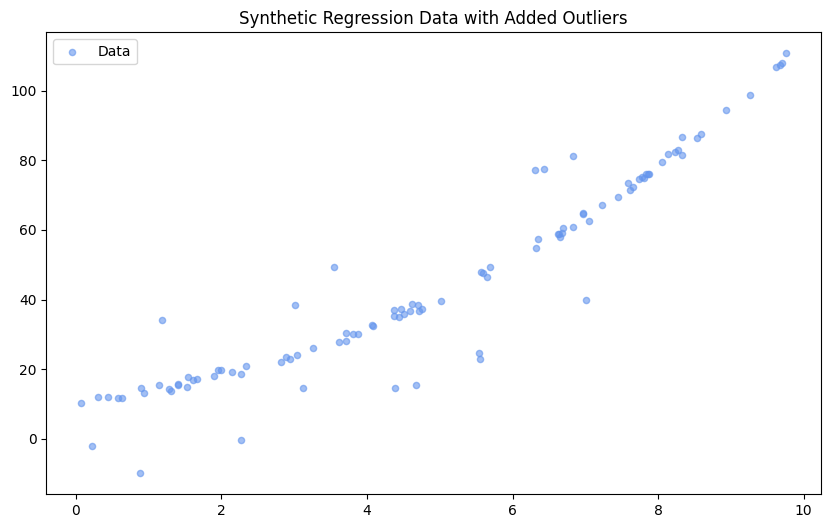

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from machinegnostics.models import GnosticDecisionTreeRegressor, train_test_split
from machinegnostics.metrics import mean_squared_error, r2_score, robr2
from machinegnostics.data import make_regression_check_data

# Generate data
X, y = make_regression_check_data(n_samples=100, degree=3, function_type='poly', noise_level=1, outlier_ratio=0.15)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_seed=42, shuffle=True)

print(f"Dataset: {X.shape[0]} samples")
print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='cornflowerblue', label='Data', alpha=0.6, s=20)
plt.title("Synthetic Regression Data with Added Outliers")
plt.legend()
plt.show()

In [16]:
# Initialize and train Gnostic Regressor
model = GnosticDecisionTreeRegressor(
    max_depth=5,
    gnostic_weights=True,
    max_iter=20,
    verbose=False
)

print("Training Gnostic Decision Tree Regressor...")
model.fit(X_train, y_train)

print(f"\nModel trained!")

Training Gnostic Decision Tree Regressor...

Model trained!


Model Performance (Test Set):
MSE: 6.0022
R2 Score: 0.8855
Robust R2 Score: 0.8915


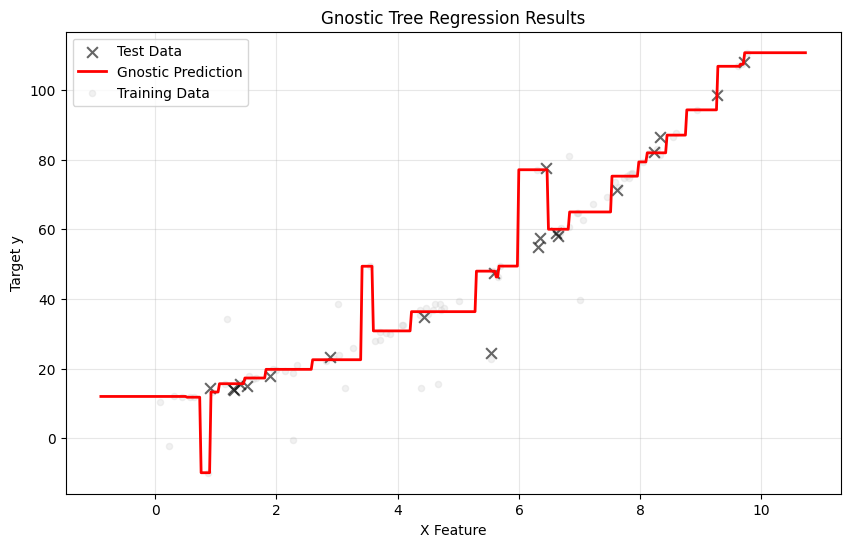

In [17]:
# Predict and Evaluate
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
robr2_score = robr2(y_test, y_pred_test)

print("Model Performance (Test Set):")
print("=" * 40)
print(f"MSE: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Robust R2 Score: {robr2_score:.4f}")
print("=" * 40)

# Compare with simple visualization
# Create a grid across the full range of X (plus a small buffer)
x_min, x_max = X.min(), X.max()
x_range = x_max - x_min
X_grid = np.linspace(x_min - 0.1 * x_range, x_max + 0.1 * x_range, 500)[:, np.newaxis]

y_grid_pred = model.predict(X_grid)

plt.figure(figsize=(10, 6))
# Plot test data
plt.scatter(X_test, y_test, color='black', label='Test Data', alpha=0.6, marker='x', s=60)
# Plot the regression line
plt.plot(X_grid, y_grid_pred, color='red', linewidth=2, label='Gnostic Prediction')
# Show 'true' function if possible (approximate since we added noise) or just training data background
plt.scatter(X_train, y_train, color='lightgray', label='Training Data', alpha=0.3, s=20, zorder=0)

plt.title("Gnostic Tree Regression Results")
plt.xlabel("X Feature")
plt.ylabel("Target y")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Example 2: Understanding Gnostic Weights

The gnostic weights should be lower for the outliers we introduced.

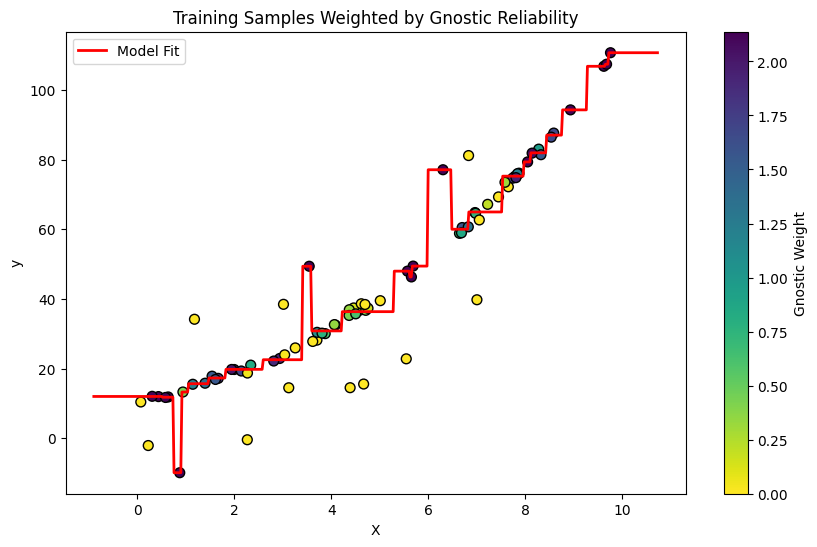

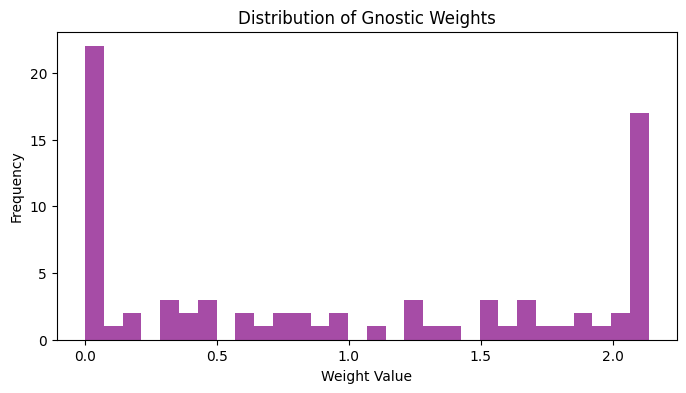

In [18]:
# Visualize Gnostic Weights
weights = model.weights

plt.figure(figsize=(10, 6))

# Plot data points, colored by weight
# High weight = Regular data (Blue/Dark)
# Low weight = Outlier (Yellow/Light)
sc = plt.scatter(X_train, y_train, c=weights, cmap='viridis_r', s=50, edgecolors='k')
plt.plot(X_grid, y_grid_pred, color='red', linewidth=2, label='Model Fit')
plt.colorbar(sc, label='Gnostic Weight')

plt.title("Training Samples Weighted by Gnostic Reliability")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

# Histogram of weights
plt.figure(figsize=(8, 4))
plt.hist(weights, bins=30, color='purple', alpha=0.7)
plt.title("Distribution of Gnostic Weights")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.show()

## Model History

Tracking the convergence of the model fit.

Metrics available: dict_keys(['iteration', 'h_loss', 'rentropy', 'weights'])


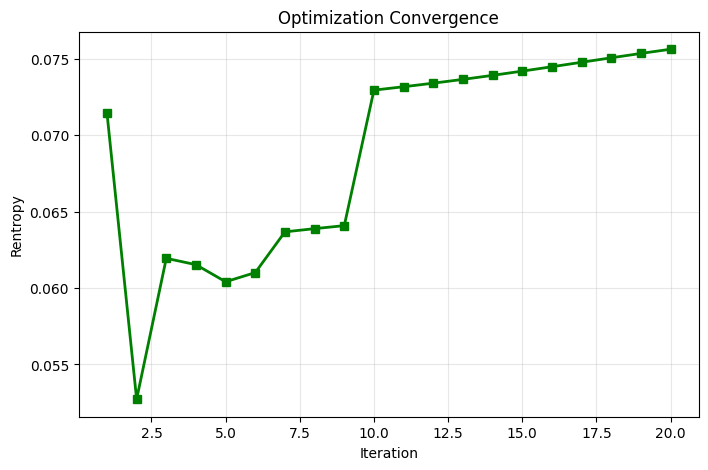

In [19]:
history = model._history

if len(history) > 1:
    iterations = [h['iteration'] for h in history if h['iteration'] is not None]
    
    # In regression, we might track R2 or just internal loss metrics
    # Let's inspect what's in history
    print(f"Metrics available: {history[1].keys()}")
    
    # Assuming 'rentropy' or similar global metric is tracked
    metrics_to_plot = 'rentropy'
    if metrics_to_plot in history[1]:
        values = [h[metrics_to_plot] for h in history if h['iteration'] is not None]
        
        plt.figure(figsize=(8, 5))
        plt.plot(iterations, values, 'g-s', linewidth=2)
        plt.title('Optimization Convergence')
        plt.xlabel('Iteration')
        plt.ylabel(metrics_to_plot.capitalize())
        plt.grid(True, alpha=0.3)
        plt.show()
else:
    print("Model converged in 1 iteration or history not available.")